In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
from matplotlib.lines import Line2D

In [53]:
plt.rc("font",size=14)

In [3]:
days = [20,21,28,29,30]

## i/o

In [4]:
# fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/UST_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
# df_ust = pd.read_csv(fname, index_col=[0], parse_dates=True)

In [37]:
for iday,day in enumerate(days):

    start = pd.to_datetime('2015-{0}-{1} 14:10'.format(3,day))
    end   = pd.to_datetime('2015-{0}-{1} 23:50'.format(3,day))
    idx   = pd.date_range(start=start, end=end, freq='10min')  
    idx.freq=None
    
    fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/UST_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    df_ust = pd.read_csv(fname, index_col=[0], parse_dates=True)
    df_ust = df_ust.reindex(index=idx)
    df_ust = pd.Series(index=df_ust.index,data=np.ravel(df_ust.values))

    fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/HFX_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    df_hfx = pd.read_csv(fname, index_col=[0], parse_dates=True)
    df_hfx = df_hfx.reindex(index=idx)
    df_hfx = pd.Series(index=df_hfx.index,data=np.ravel(df_hfx.values))
    
    fname  = "/Volumes/Baby-Orange/XPIA-NCAR/processed/PBLH_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day)
    df_zi = pd.read_csv(fname, index_col=[0], parse_dates=True)
    df_zi.index = df_zi.index.tz_localize(None)
    df_zi = pd.Series(index=df_zi.index,data=df_zi['median'].values)
    df_zi = df_zi.reindex(index=idx)

    df_theta = df_zi.copy() * 0.0 + 300.0

    df_wst = ((9.81/df_theta)* df_zi * df_hfx)**(1/3.)

    if iday==0:
        df_ust_final = df_ust.copy()
        df_wst_final = df_wst.copy()
        df_zi_final  = df_zi.copy()
    else:
        df_ust_final = pd.concat([df_ust_final,df_ust],axis=0)
        df_wst_final = pd.concat([df_wst_final,df_wst],axis=0)    
        df_zi_final  = pd.concat([df_zi_final,df_zi],axis=0)            

## functions

In [38]:
def p_nl(delta_star,C_cs=None,ust=None,wst=None):
    
    # Hyeyum Hailey Shin and Song-You Hong, “Representation of the Subgrid-Scale Turbulent Transport in Convective Boundary Layers at Gray-Zone Resolutions,” Monthly Weather Review 143, no. 1 (January 1, 2015): 250–71, https://doi.org/10.1175/MWR-D-14-00116.1.
    # Eqs. [2] & [3]
    
    if C_cs==None:
        a_cs = 0.5
        b_cs = -40.0
        c_cs = -0.5
        d_cs = 8.0
        e_cs = 3.0

        arg           = b_cs * np.abs(ust/wst+c_cs) + d_cs
        C_cs          = a_cs * (np.tanh(arg)+e_cs)    

    delta_star_cs = delta_star/C_cs
    
    top = delta_star_cs**2 + 0.936*delta_star_cs**(7/8.) - 1.110
    bot = delta_star_cs**2 + 0.312*delta_star_cs**(7/8.) + 0.329
    
    return C_cs,0.243*top/bot+0.757

def p_l(delta_star):
    
    # Hyeyum Hailey Shin and Song-You Hong, “Representation of the Subgrid-Scale Turbulent Transport in Convective Boundary Layers at Gray-Zone Resolutions,” Monthly Weather Review 143, no. 1 (January 1, 2015): 250–71, https://doi.org/10.1175/MWR-D-14-00116.1.
    # Eq. [7]
  
    top = delta_star**2 + 0.870*delta_star**(0.5) - 0.913
    bot = delta_star**2 + 0.153*delta_star**(0.5) + 0.278

    return 0.280*top/bot+0.720

## theoretical values

In [39]:
delta_star = np.arange(0.0,10.01,0.01)

local            = p_l(delta_star)
C_cs, non_local  = p_nl(delta_star,C_cs=1.0)

# force negative values to zero, as in the paper
idx        = np.where(local<0)
local[idx] = 0.0

idx        = np.where(non_local<0)
non_local[idx] = 0.0

# force values >1 to 1, as in the paper
idx        = np.where(local>1)
local[idx] = 1.0

idx        = np.where(non_local>1)
non_local[idx] = 1.0

## actual values

In [40]:
delta              = 333.0 
delta_star_actual  = delta/df_zi_final

local_actual = p_l(delta_star_actual.values)
C_s, non_local_actual = p_nl(delta_star_actual.values,ust=df_ust_final.values,wst=df_wst_final.values)

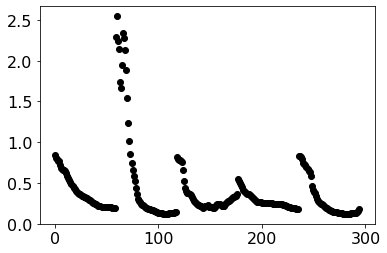

In [41]:
plt.plot(delta_star_actual.values, 'ok')

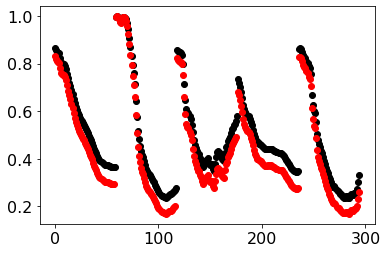

In [42]:
plt.figure()
plt.plot(local_actual,'ok')
plt.plot(non_local_actual,'or')

## get histogram of actual values of p_l and p_nl

In [26]:
bins        = np.arange(-2, 1.01, 0.2)
vals, bins  = np.histogram(np.log10(local_actual), bins=bins, density=False)
perc_vals   = (vals/np.sum(vals) * 100)
bin_centers = (bins[1:]+bins[0:-1])/2

In [27]:
bins              = np.arange(-2, 1.01, 0.2)
vals_nl, bins_nl  = np.histogram(np.log10(non_local_actual), bins=bins, density=False)
perc_vals_nl      = (vals_nl/np.sum(vals_nl) * 100)
bin_centers_nl    = (bins_nl[1:]+bins_nl[0:-1])/2

## get histogram of u*/w* ==> always < 0.1!!!

In [28]:
bins                    = np.arange(0.0, 1.01, 0.1)
vals_stars, bins_stars  = np.histogram(df_ust_final.values/df_wst_final.values, bins=bins, density=False)
perc_vals_stars         = (vals_stars/np.sum(vals_stars) * 100)
bin_centers_stars       = (bins_stars[1:]+bins_stars[0:-1])/2

## plot

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


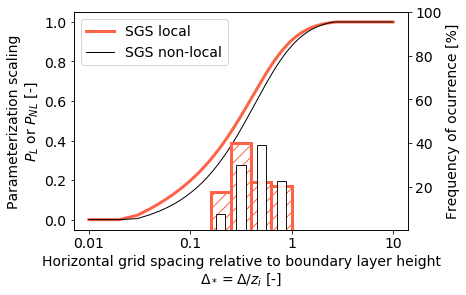

In [41]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(np.log10(delta_star),local,'-',color='tomato',lw=3,label='SGS local')
ax.plot(np.log10(delta_star),non_local,'-k',label='SGS non-local',lw=1,zorder=10)
ax.set_ylim([-0.05,1.05])
ax.set_ylabel("Parameterization scaling\n$P_L$ or $P_{NL}$ [-]")
plt.legend()

ax2 = ax.twinx()
ax2.bar(bin_centers_nl,perc_vals_nl,width=0.2,edgecolor='tomato',ls='-',color='white',lw=3,alpha=1,hatch='//')
ax2.bar(bin_centers,perc_vals,width=0.09,edgecolor='k',color='w',lw=1,alpha=0.9)
ax2.set_ylim([0.5,100])
ax2.set_ylabel("Frequency of ocurrence [%]")

ax.set_xticks([-2,-1,0,1])
ax.set_xticklabels([str(a) for a in [0.01,0.1,1,10]])
ax.set_xlabel("Horizontal grid spacing relative to boundary layer height\n$\Delta_*=\Delta/z_i$ [-]")

fig.savefig("../figs/PL_PNL.png",dpi=250,bbox_inches="tight")

## time series plots

In [9]:
colors_days = {20:'#ABB2B9',
               21:'#5DADE2',
               28:'#16A085',
               29:'#D4AC0D',
               30:'#A569BD'}

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fs=16
plt.rc("font",size=fs)

In [44]:
local = pd.Series(index=delta_star_actual.index,data=local_actual)
non_local = pd.Series(index=delta_star_actual.index,data=non_local_actual)

In [161]:
hours_to_tick = np.arange(14,24,1)

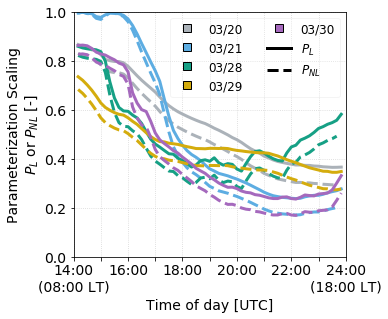

In [169]:
start = pd.Timestamp('20180606')

fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111)

iday = 0
for day in days:
    
    series = local.loc['2015-03-{0}'.format(day)].copy()
    idxref = pd.Timestamp(series.index.year[0], series.index.month[0], series.index.day[0], 14, 0)
    deltas = series.index - idxref + pd.Timedelta('14h')
    index  = start+deltas
    
    ax.plot(index,
            series.values,color=colors_days[day],linestyle='-',lw=3,
            marker='None',label='March {0}'.format(day))

    series = non_local.loc['2015-03-{0}'.format(day)].copy()    
    ax.plot(index,
            series.values,color=colors_days[day],linestyle='--',lw=3,
            marker='None',label='March {0}'.format(day))        

indices_to_tick = [np.where(index.hour==h)[0][0] for h in hours_to_tick][1:]
xticks = [index[i] for i in indices_to_tick]
xticks.append(pd.Timestamp(start+pd.Timedelta('24h')))
xticks.append(pd.Timestamp(start+pd.Timedelta('14h')))
xticks = np.sort(xticks)
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xticklabels(["14:00\n(08:00 LT)","","16:00","","18:00","","20:00","","22:00","","24:00\n(18:00 LT)"])
ax.set_xlim([xticks[0],xticks[-1]])

ax.set_xlabel("Time of day [UTC]")

ax.grid(color='lightgray',linestyle=':')

ylab       = "Parameterization Scaling\n$P_L$ or $P_{NL}$ [-]"
ax.set_ylabel(ylab)

ax.set_ylim([0,1])

lines  = []
labels = []

for day in days:
    lines.append(Line2D([0], [0], color=colors_days[day], linewidth=0, marker='s', ms=8, mec='k',mew=1))
    labels.append('03/{0}'.format(day))
    
lines.append(Line2D([0], [0], color='k', linewidth=3, marker=None, linestyle='-'))
labels.append('$P_L$')    

lines.append(Line2D([0], [0], color='k', linewidth=3, marker=None, linestyle='--'))
labels.append('$P_{{NL}}$')    

lg = plt.legend(lines,labels,ncol=2,fontsize=12,framealpha=0.2)
fig.subplots_adjust(left=0.25,bottom=0.2,right=0.88)
fig.savefig("../figs/P_L_P_NL_diurnal_cycles.png",dpi=300,bbox_inches="tight")